# Neural Network Models

First we need to load all the packages necessary for this notebook. In order to install the packages run pip install requirements.txt

In [18]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import random

Next we get the data using the environment variable ```RESEARCH_DATA_PATH``` which should direct to the data folder of this project

In [3]:
DATA_PATH = os.environ.get("RESEARCH_DATA_PATH")

In [4]:
#MONTHLY DATA
X_mef_m = pd.read_csv(f'{DATA_PATH}/processed/mef_monthly_data_processed.csv')
X_mai_m = pd.read_csv(f'{DATA_PATH}/processed/mai_monthly_data_processed.csv')
y_mkt_m = pd.read_csv(f'{DATA_PATH}/processed/mkt_monthly_data_processed.csv')

X_mef_m['date'] = pd.to_datetime(X_mef_m['date'])
X_mai_m['date'] = pd.to_datetime(X_mai_m['date'])
y_mkt_m['date'] = pd.to_datetime(y_mkt_m['date'])

# Drop the 'date' column from each dataset
X_mef_m = X_mef_m.drop('date', axis=1)
X_mai_m = X_mai_m.drop('date', axis=1)
y_mkt_m = y_mkt_m.drop('date', axis=1)

X_mef_m = X_mef_m.values
X_mai_m = X_mai_m.values
y_mkt_m = y_mkt_m.values

#DAILY DATA
X_mef_d = pd.read_csv(f'{DATA_PATH}/processed/mef_daily_data_processed.csv')
X_mai_d = pd.read_csv(f'{DATA_PATH}/processed/mai_daily_data_processed.csv')
y_mkt_d = pd.read_csv(f'{DATA_PATH}/processed/mkt_daily_data_processed.csv')

X_mef_d['date'] = pd.to_datetime(X_mef_d['date'])
X_mai_d['date'] = pd.to_datetime(X_mai_d['date'])
y_mkt_d['date'] = pd.to_datetime(y_mkt_d['date'])

# Drop the 'date' column from each dataset
X_mef_d = X_mef_d.drop('date', axis=1)
X_mai_d = X_mai_d.drop('date', axis=1)
y_mkt_d = y_mkt_d.drop('date', axis=1)

X_mef_d = X_mef_d.values
X_mai_d = X_mai_d.values
y_mkt_d = y_mkt_d.values

Now we define functions for train-test split, the network architecture and training of the model (seperately for MEF and MAI datasets) and to test the trained models.

In [5]:
# Function: split data into training and test set based on the random state
def split_data(X, y, test_size, random_state):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=test_size,random_state=random_state)
    return X_train, y_train, X_test, y_test

In [6]:
# Function: build the neural network model for MAI data

def train_neural_network_MAI(X, y):
    """
    Parameters:
    - X: MAI features
    - y: Target variable

    Returns:
    - Trained model
    - Model training history
    """

    # the best number of layers, dropout layers, the best number of units of a layer have been selected
    model = keras.Sequential([
    layers.Dense(64, activation=keras.layers.ELU(),input_dim=8),
    Dropout(0.3),
    layers.Dense(32, activation=keras.layers.ELU()),
    Dropout(0.5),
    layers.Dense(1)  # Output layer with 1 neuron for numerical output
    ])

    # Compile the model
    # the best optimizer and learning rate have been selected
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])

    # Train the model
    # the best number of epochs and batch_size have been selected
    history = model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

    # Plot training and validation accuracy over epochs
    # plt.plot(history.history['loss'], label='Training MSE')
    # plt.plot(history.history['val_loss'], label='Validation MSE')
    # plt.xlabel('Epoch')
    # plt.ylabel('Accuracy')
    # plt.legend()
    # plt.show()

    mse_values = history.history['loss']
    mse_values_val = history.history['val_loss']

    avg_RMSE_train = np.mean([mse_value ** 0.5 for mse_value in mse_values])
    avg_RMSE_test = np.mean([mse_value_val ** 0.5 for mse_value_val in mse_values_val])

    return model, history, avg_RMSE_train, avg_RMSE_test

In [7]:
# Function: build the neural network model for MEF data

def train_neural_network_MEF(X, y):
    """
    Parameters:
    - X: MEF features
    - y: Target variable

    Returns:
    - Trained model
    - Model training history
    """

    # the best number of layers, dropout layers, the best number of units of a layer have been selected
    model = keras.Sequential([
    layers.Dense(64, activation=keras.layers.ELU(),input_dim=14),
    Dropout(0.3),
    layers.Dense(32, activation=keras.layers.ELU()),
    Dropout(0.5),
    layers.Dense(1)  # Output layer with 1 neuron for numerical output
    ])

    # Compile the model
    # the best optimizer and learning rate have been selected
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])

    # Train the model
    # the best number of epochs and batch_size have been selected
    history = model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

    # Plot training and validation accuracy over epochs
    # plt.plot(history.history['loss'], label='Training MSE')
    # plt.plot(history.history['val_loss'], label='Validation MSE')
    # plt.xlabel('Epoch')
    # plt.ylabel('Accuracy')
    # plt.legend()
    # plt.show()
    mse_values = history.history['loss']
    mse_values_val = history.history['val_loss']

    avg_RMSE_train = np.mean([mse_value ** 0.5 for mse_value in mse_values])
    avg_RMSE_test = np.mean([mse_value_val ** 0.5 for mse_value_val in mse_values_val])

    return model, history, avg_RMSE_train, avg_RMSE_test

In [8]:
#Function: evaluate the performance of the model and show the values in plot
def test_model(model, X_test, y_test):
    """
    Test a trained model and calculate regression metrics.

    Parameters:
    - model: Trained model
    - X_test: Testing features
    - y_test: True values for testing

    Returns:
    - Mean Squared Error (MSE)
    - Mean Absolute Error (MAE)
    - R-squared (R2) score
    """

    # Make y_pred using the trained model
    y_pred = model.predict(X_test)

    # Calculate regression metrics
    MSE = mean_squared_error(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    R2 = r2_score(y_test, y_pred)

    # Plot predicted values and true values

    new_y_test = [value for index, value in enumerate(y_test)]
    plt.plot(new_y_test, label='True',color='blue')
    plt.plot(y_pred, label='Prediction',color='red')

    plt.xlabel('Index')
    plt.ylabel('y values')
    plt.title('True vs Pred')

    plt.legend()

    plt.show()

    return MSE, MAE, R2

## Neural Networks with monthly data

As a first approach, we will try to train the Neural Networks using the datasets with monthly data. However we do not expect these models to perform efficiently due to the small size of the datasets (408 points), which is not sufficient for the complexity of a neural network.

In order to achieve more robust results, we will train the networks 10 times over different train-test splits and report the average RMSE.

We start with the MAI data.

Epoch 1/10


C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2540.5659 - mae: 38.9344 - val_loss: 3969.3347 - val_mae: 41.3413
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2656.1157 - mae: 40.0151 - val_loss: 3967.2200 - val_mae: 41.3382
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2598.4741 - mae: 39.8259 - val_loss: 3964.5520 - val_mae: 41.3342
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2580.6272 - mae: 38.2948 - val_loss: 3962.2664 - val_mae: 41.3306
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2638.8552 - mae: 39.5739 - val_loss: 3961.0422 - val_mae: 41.3296
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2781.5671 - mae: 40.5959 - val_loss: 3959.2405 - val_mae: 41.3290
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2442.8970 - mae: 37.8936 - val_loss: 3957.4871 - val_mae: 41.3286
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2418.1763 - mae: 37.3984 - val_loss: 3955.2639 - val_mae: 41.3277
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━

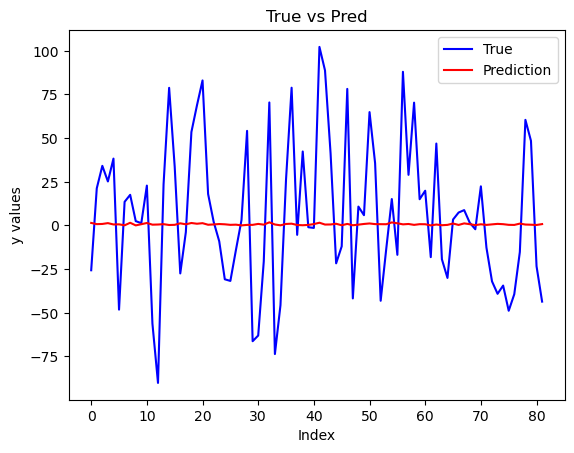

RMSE: 42.4797729868916, MAE: 33.96193814471704, R2: -0.0157011265049829
Epoch 1/10


C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2374.1829 - mae: 37.2449 - val_loss: 1583.5260 - val_mae: 34.8648
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3199.9771 - mae: 40.4130 - val_loss: 1584.0898 - val_mae: 34.8548
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2903.2898 - mae: 40.8085 - val_loss: 1584.6367 - val_mae: 34.8443
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2979.0620 - mae: 39.4450 - val_loss: 1585.0333 - val_mae: 34.8372
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2491.8816 - mae: 37.9610 - val_loss: 1585.5195 - val_mae: 34.8302
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2594.9277 - mae: 37.1656 - val_loss: 1586.0768 - val_mae: 34.8222
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2838.6267 - mae: 39.0351 - val_loss: 1586.3530 - val_mae: 34.8201
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2838.2761 - mae: 37.0042 - val_loss: 1586.7994 - val_mae: 34.8146
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━

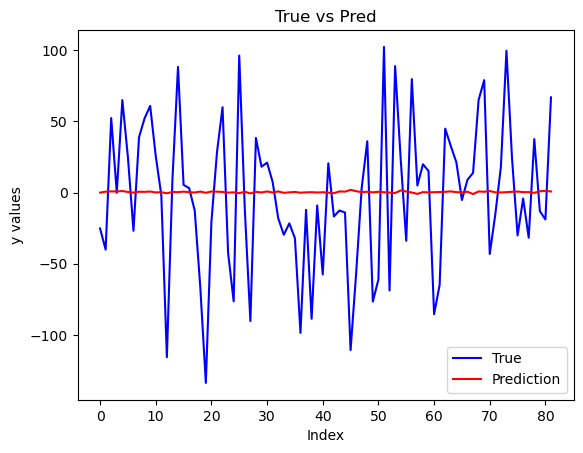

RMSE: 52.37987798554125, MAE: 41.40577250655773, R2: -0.0016304188248064122
Epoch 1/10


C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2414.3826 - mae: 37.3373 - val_loss: 2671.9990 - val_mae: 40.5620
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2359.1074 - mae: 35.9491 - val_loss: 2671.9365 - val_mae: 40.5391
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1943.0715 - mae: 33.9168 - val_loss: 2671.7881 - val_mae: 40.5165
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2239.0447 - mae: 37.0925 - val_loss: 2671.6873 - val_mae: 40.4973
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2377.6953 - mae: 36.7642 - val_loss: 2671.4897 - val_mae: 40.4778
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2040.7919 - mae: 34.1398 - val_loss: 2671.4285 - val_mae: 40.4574
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2267.6741 - mae: 35.9811 - val_loss: 2671.3154 - val_mae: 40.4351
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2627.5493 - mae: 39.4956 - val_loss: 2671.2476 - val_mae: 40.4146
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━

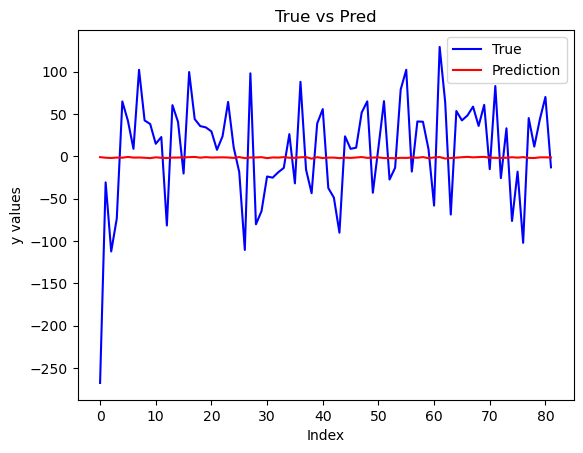

RMSE: 62.69610806814232, MAE: 49.88961795819952, R2: -0.0239056427197335
Epoch 1/10


C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3000.9099 - mae: 39.5578 - val_loss: 1946.4264 - val_mae: 38.5529
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2730.9663 - mae: 40.0444 - val_loss: 1946.0488 - val_mae: 38.5165
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2754.8730 - mae: 38.5102 - val_loss: 1945.7734 - val_mae: 38.4871
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2570.5969 - mae: 38.0319 - val_loss: 1945.4899 - val_mae: 38.4562
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2876.6882 - mae: 40.3155 - val_loss: 1945.2051 - val_mae: 38.4275
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3026.9473 - mae: 41.9979 - val_loss: 1945.0293 - val_mae: 38.4053
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2548.8726 - mae: 37.5713 - val_loss: 1944.8900 - val_mae: 38.3842
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2536.9910 - mae: 38.5662 - val_loss: 1944.6870 - val_mae: 38.3588
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━

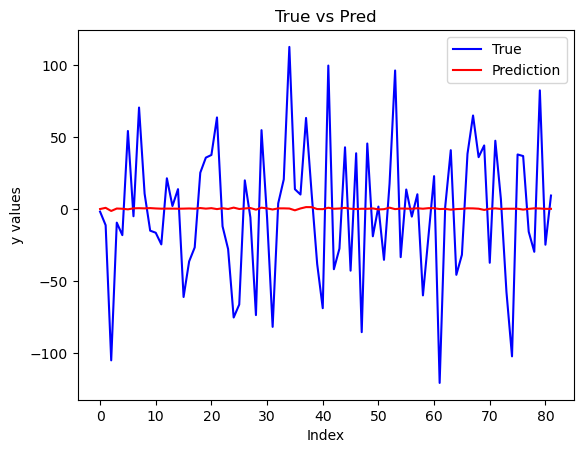

RMSE: 47.49826109033307, MAE: 37.747842106533284, R2: 0.0029167656963832167
Epoch 1/10


C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3178.9236 - mae: 40.8134 - val_loss: 1793.8143 - val_mae: 37.5480
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3043.4221 - mae: 40.2585 - val_loss: 1793.1754 - val_mae: 37.5370
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2665.3271 - mae: 39.6213 - val_loss: 1792.4712 - val_mae: 37.5240
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3079.7283 - mae: 41.7704 - val_loss: 1791.8403 - val_mae: 37.5119
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2497.3376 - mae: 38.7497 - val_loss: 1791.0840 - val_mae: 37.4972
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3486.0898 - mae: 43.1937 - val_loss: 1791.1368 - val_mae: 37.4988
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2940.1936 - mae: 40.7905 - val_loss: 1790.9019 - val_mae: 37.4948
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3021.9299 - mae: 41.6236 - val_loss: 1790.6991 - val_mae: 37.4922
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━

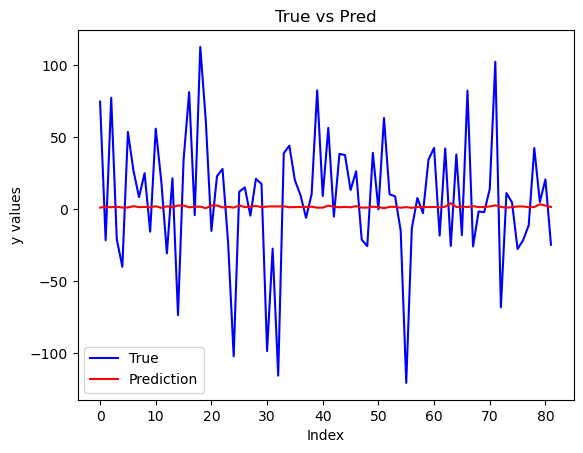

RMSE: 44.61821813625141, MAE: 33.5186490376108, R2: -0.024897945838760815
Epoch 1/10


C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2820.9741 - mae: 39.3276 - val_loss: 2153.3206 - val_mae: 32.9617
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3208.1057 - mae: 41.1163 - val_loss: 2155.4553 - val_mae: 32.9326
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2426.4734 - mae: 37.4587 - val_loss: 2157.3782 - val_mae: 32.9065
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2497.8455 - mae: 37.7252 - val_loss: 2159.2483 - val_mae: 32.8829
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2638.4382 - mae: 38.9621 - val_loss: 2160.5530 - val_mae: 32.8658
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2666.2629 - mae: 36.9193 - val_loss: 2162.0764 - val_mae: 32.8459
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3145.5798 - mae: 40.0665 - val_loss: 2164.1035 - val_mae: 32.8199
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2392.3076 - mae: 36.3057 - val_loss: 2165.3894 - val_mae: 32.8038
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━

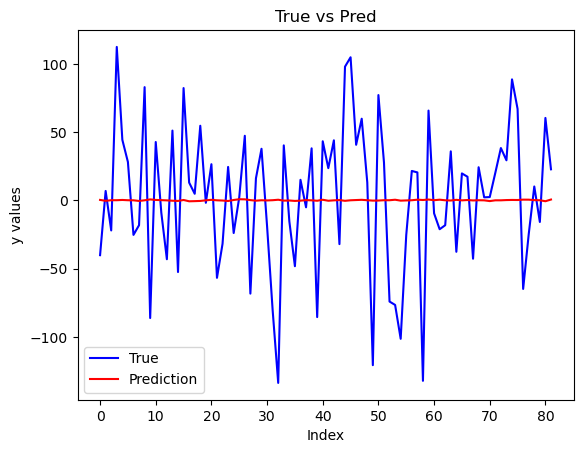

RMSE: 53.3644326785459, MAE: 42.87087253411848, R2: -0.0023647403022679647
Epoch 1/10


C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2385.4858 - mae: 37.6749 - val_loss: 3264.2100 - val_mae: 40.5499
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2284.2061 - mae: 36.8834 - val_loss: 3258.5693 - val_mae: 40.5229
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2254.1509 - mae: 37.0128 - val_loss: 3253.4326 - val_mae: 40.4976
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2106.4824 - mae: 35.8288 - val_loss: 3250.1941 - val_mae: 40.4794
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2144.8706 - mae: 36.0408 - val_loss: 3246.1521 - val_mae: 40.4583
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2175.0132 - mae: 36.5472 - val_loss: 3241.8984 - val_mae: 40.4365
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2289.4685 - mae: 36.5799 - val_loss: 3238.3372 - val_mae: 40.4185
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2657.7161 - mae: 39.8496 - val_loss: 3233.8586 - val_mae: 40.3956
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━

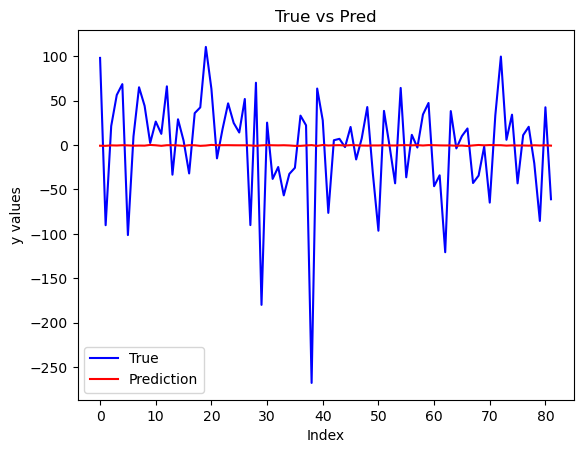

RMSE: 59.84860690367912, MAE: 43.99033503375478, R2: -0.001041739714618961
Epoch 1/10


C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2405.1538 - mae: 37.1976 - val_loss: 2668.5723 - val_mae: 45.0317
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2677.4316 - mae: 37.1650 - val_loss: 2668.7668 - val_mae: 45.0307
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2212.7014 - mae: 36.6237 - val_loss: 2669.6692 - val_mae: 45.0184
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1989.1543 - mae: 34.3278 - val_loss: 2670.5161 - val_mae: 45.0061
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2033.6355 - mae: 33.6100 - val_loss: 2671.4050 - val_mae: 44.9941
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2268.3245 - mae: 36.7850 - val_loss: 2672.5967 - val_mae: 44.9763
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2553.5688 - mae: 37.8850 - val_loss: 2673.7456 - val_mae: 44.9591
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2243.9524 - mae: 36.4806 - val_loss: 2674.8242 - val_mae: 44.9433
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━

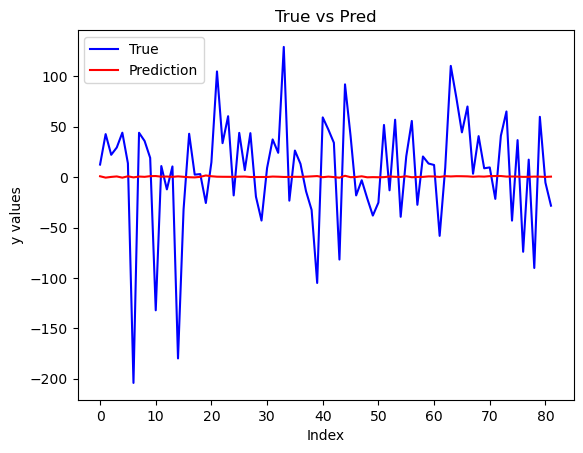

RMSE: 55.95921702213362, MAE: 41.471159607947016, R2: -0.012359344387248727
Epoch 1/10


C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3053.3157 - mae: 40.1479 - val_loss: 1613.9169 - val_mae: 35.5085
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2374.1658 - mae: 36.3162 - val_loss: 1613.9126 - val_mae: 35.5136
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2554.5142 - mae: 37.7013 - val_loss: 1613.9852 - val_mae: 35.5125
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2635.0049 - mae: 38.2880 - val_loss: 1613.9999 - val_mae: 35.5151
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3100.4375 - mae: 40.1744 - val_loss: 1614.0259 - val_mae: 35.5129
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2863.2869 - mae: 39.8105 - val_loss: 1614.0001 - val_mae: 35.5160
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3451.8955 - mae: 43.2205 - val_loss: 1614.0536 - val_mae: 35.5115
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2836.4185 - mae: 39.0210 - val_loss: 1614.1549 - val_mae: 35.5082
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━

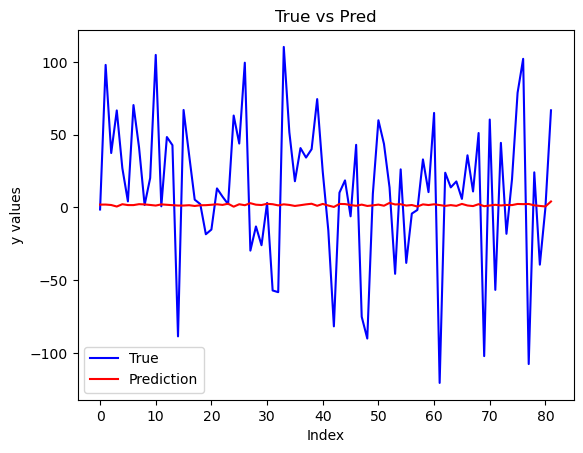

RMSE: 50.840774950854794, MAE: 39.540987279356564, R2: -0.049928607554479365
Epoch 1/10


C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2820.8516 - mae: 40.2294 - val_loss: 1921.2574 - val_mae: 37.7585
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2397.5559 - mae: 38.2690 - val_loss: 1919.1976 - val_mae: 37.7454
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3096.1326 - mae: 42.2399 - val_loss: 1918.2958 - val_mae: 37.7399
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2517.7090 - mae: 37.9457 - val_loss: 1916.9961 - val_mae: 37.7319
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2572.7549 - mae: 39.2640 - val_loss: 1915.4645 - val_mae: 37.7222
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2756.7737 - mae: 40.0540 - val_loss: 1913.6240 - val_mae: 37.7108
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2498.2507 - mae: 38.9963 - val_loss: 1912.4586 - val_mae: 37.7040
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2317.5020 - mae: 36.9857 - val_loss: 1910.6934 - val_mae: 37.6925
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━

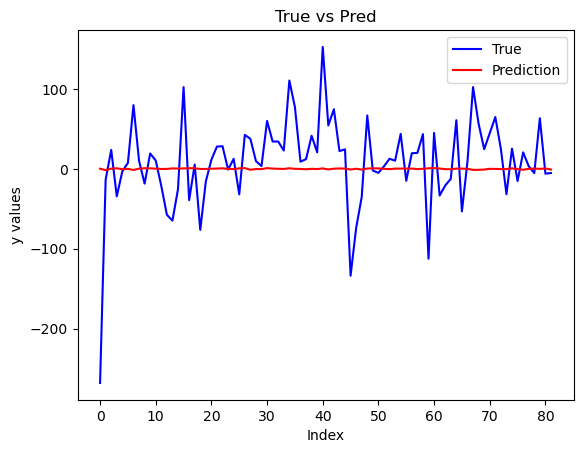

RMSE: 56.127553331328954, MAE: 38.746680629565994, R2: -0.02502473161576102
 
The average test RMSE over 10 iterations for MAI monthly data is: 52.581282315370196


In [22]:
# Test the performance of the model on 10 different random train-test splits of MAI monthly data, and report the average RMSE.
list_RMSE_train_train=[]
list_RMSE_train_val=[]
list_RMSE=[]

np.random.seed(11)
random.seed(11)

for i in range(0,10):
  # Generate training and test data sets
  X_train, y_train, X_test, y_test = split_data(X_mai_m, y_mkt_m, 0.2, i)

  # Use X_train and y_train as MAI features and target variable
  trained_model, training_history, avg_RMSE_train, avg_RMSE_test = train_neural_network_MAI(X_train, y_train)
  print('During training of this NN model, average training RMSE is', avg_RMSE_train, ', average validation RMSE is', avg_RMSE_test)
  list_RMSE_train_train.append(avg_RMSE_train)
  list_RMSE_train_val.append(avg_RMSE_test)

  # Have the performance of the trained model evaluated on the test set
  MSE, MAE, R2 = test_model(trained_model, X_test, y_test)
  print(f'RMSE: {MSE**(1/2)}, MAE: {MAE}, R2: {R2}')
  list_RMSE.append(MSE**(1/2))
avg_RMSE=np.mean(list_RMSE)
print(' ')
print('The average test RMSE over 10 iterations for MAI monthly data is:', avg_RMSE)

Text(0.5, 1.0, 'Distribution of RMSE over Iterations (MAI monthly training data)')

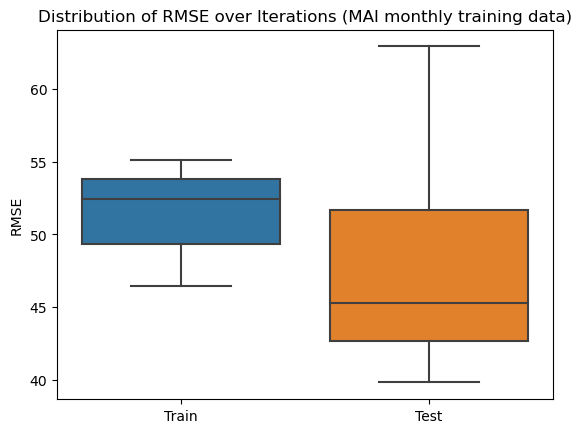

In [23]:
sns.boxplot(data=[list_RMSE_train_train, list_RMSE_train_val])
plt.xticks([0, 1], ['Train', 'Test'])
plt.ylabel('RMSE')
plt.title('Distribution of RMSE over Iterations (MAI monthly training data)')

The standard variation of RMSE is 6.116219652466703


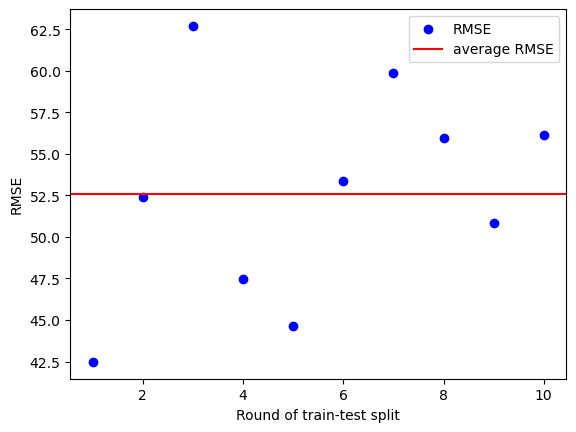

In [24]:
# Calculate the standard variation of RMSE
print('The standard variation of RMSE is', np.std(list_RMSE))
# Plot the RMSE of each round of random split
plt.scatter(y=list_RMSE,x=range(1,11),label='RMSE',color='blue')
plt.axhline(y=avg_RMSE, label='average RMSE',linestyle='-',color='red')

plt.xlabel('Round of train-test split')
plt.ylabel('RMSE')
#plt.title('RMSE of each round of random split, NN on MAI monthly')

plt.legend()

plt.show()

Now we do the same with the MEF monthly data.

Epoch 1/10


C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2676.5283 - mae: 39.6919 - val_loss: 3996.3040 - val_mae: 41.4446
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2719.4302 - mae: 39.8414 - val_loss: 3990.0554 - val_mae: 41.4325
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3162.0676 - mae: 42.7582 - val_loss: 3983.7170 - val_mae: 41.4201
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2610.3552 - mae: 39.3128 - val_loss: 3978.6707 - val_mae: 41.4102
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2632.7285 - mae: 39.4610 - val_loss: 3973.9707 - val_mae: 41.4009
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2517.2876 - mae: 38.3754 - val_loss: 3967.8972 - val_mae: 41.3888
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2651.0679 - mae: 39.5903 - val_loss: 3962.0391 - val_mae: 41.3770
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2542.8599 - mae: 38.0387 - val_loss: 3956.3203 - val_mae: 41.3689
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━

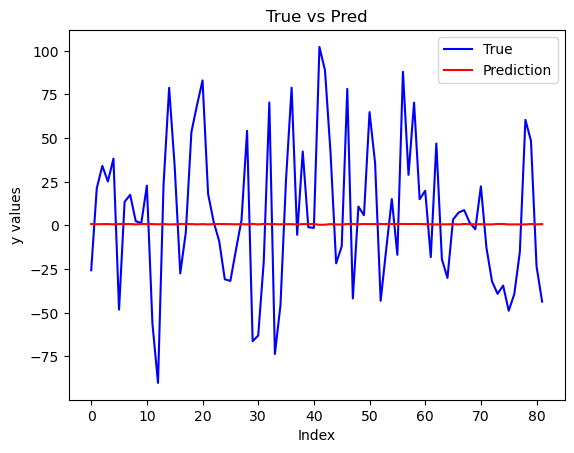

RMSE: 42.5946387102827, MAE: 34.056156550362104, R2: -0.021201484620028577
Epoch 1/10


C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2636.1270 - mae: 37.3472 - val_loss: 1589.3055 - val_mae: 34.7750
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2949.5007 - mae: 38.5147 - val_loss: 1589.9452 - val_mae: 34.7669
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2597.9612 - mae: 38.6426 - val_loss: 1590.5492 - val_mae: 34.7594
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2857.8943 - mae: 38.2809 - val_loss: 1591.2653 - val_mae: 34.7506
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2529.1082 - mae: 37.2258 - val_loss: 1591.6300 - val_mae: 34.7477
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2769.3540 - mae: 38.2259 - val_loss: 1592.1576 - val_mae: 34.7435
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2538.6375 - mae: 37.1875 - val_loss: 1592.5138 - val_mae: 34.7407
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2639.0754 - mae: 37.3722 - val_loss: 1593.1577 - val_mae: 34.7359
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━

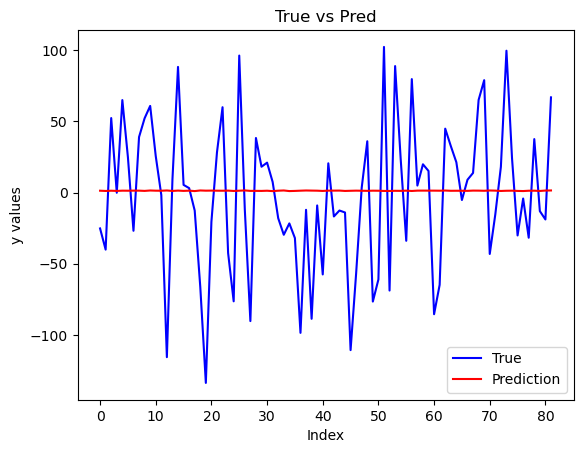

RMSE: 52.4691988315393, MAE: 41.42740326894117, R2: -0.005049394249545092
Epoch 1/10


C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2031.0393 - mae: 33.0009 - val_loss: 2678.9636 - val_mae: 39.8663
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2613.7830 - mae: 37.6983 - val_loss: 2679.0149 - val_mae: 39.8462
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2252.4487 - mae: 34.6654 - val_loss: 2679.0571 - val_mae: 39.8324
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2311.0166 - mae: 36.1188 - val_loss: 2679.1282 - val_mae: 39.8135
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2237.5391 - mae: 35.5188 - val_loss: 2679.2056 - val_mae: 39.7975
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2462.0176 - mae: 37.5332 - val_loss: 2679.2502 - val_mae: 39.7864
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2445.8350 - mae: 37.1849 - val_loss: 2679.3123 - val_mae: 39.7737
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2335.9604 - mae: 35.7183 - val_loss: 2679.4189 - val_mae: 39.7577
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━

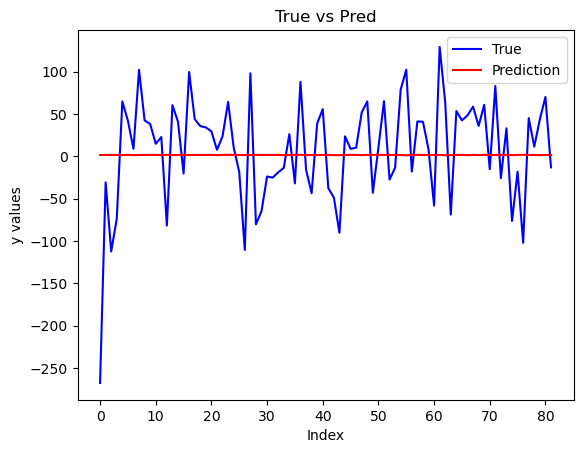

RMSE: 62.33945018721148, MAE: 49.28006560167145, R2: -0.0122894412952399
Epoch 1/10


C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2720.1008 - mae: 38.5880 - val_loss: 1943.8589 - val_mae: 38.6506
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2934.8076 - mae: 40.4491 - val_loss: 1943.5504 - val_mae: 38.6014
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2811.7588 - mae: 39.9930 - val_loss: 1943.3267 - val_mae: 38.5608
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3057.1904 - mae: 41.8057 - val_loss: 1943.2233 - val_mae: 38.5353
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3273.0798 - mae: 41.7165 - val_loss: 1943.1571 - val_mae: 38.5146
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2778.6213 - mae: 38.0541 - val_loss: 1943.1090 - val_mae: 38.5005
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3067.9656 - mae: 39.6846 - val_loss: 1943.0521 - val_mae: 38.4849
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2670.6941 - mae: 38.5052 - val_loss: 1942.9747 - val_mae: 38.4602
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━

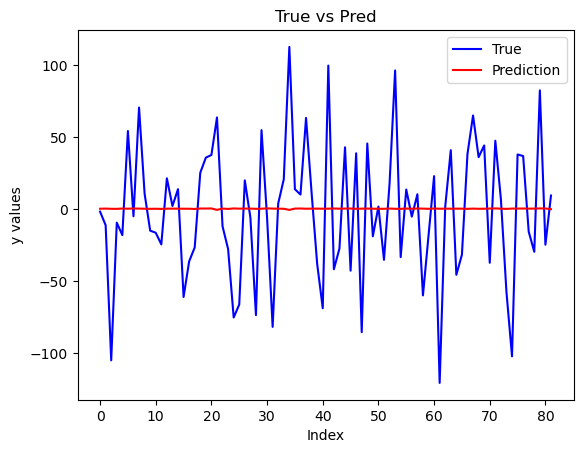

RMSE: 47.63369600087449, MAE: 37.803887786590266, R2: -0.002777438662776799
Epoch 1/10


C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2861.6428 - mae: 41.6059 - val_loss: 1819.4440 - val_mae: 37.9693
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2825.1763 - mae: 41.5788 - val_loss: 1818.6168 - val_mae: 37.9595
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2657.2412 - mae: 39.7302 - val_loss: 1817.8619 - val_mae: 37.9506
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3268.9819 - mae: 43.0424 - val_loss: 1817.0380 - val_mae: 37.9406
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2784.5457 - mae: 40.9065 - val_loss: 1816.6852 - val_mae: 37.9364
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2710.2346 - mae: 40.1000 - val_loss: 1816.1699 - val_mae: 37.9304
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2770.3447 - mae: 40.3702 - val_loss: 1815.3658 - val_mae: 37.9207
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2714.7009 - mae: 40.4476 - val_loss: 1814.4447 - val_mae: 37.9095
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━

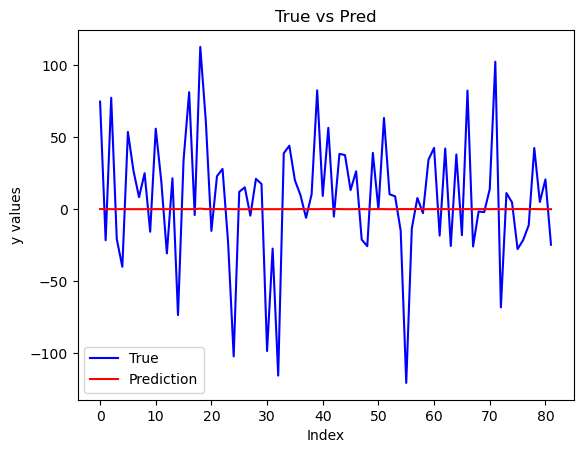

RMSE: 44.81910579892336, MAE: 33.77046493514265, R2: -0.03414765845890533
Epoch 1/10


C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2822.8423 - mae: 39.7097 - val_loss: 2177.8899 - val_mae: 32.6478
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2396.5291 - mae: 37.2824 - val_loss: 2181.2480 - val_mae: 32.6207
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2952.0361 - mae: 41.4220 - val_loss: 2182.5066 - val_mae: 32.6105
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2948.2183 - mae: 39.2939 - val_loss: 2184.4795 - val_mae: 32.5947
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2787.0703 - mae: 39.6513 - val_loss: 2187.1462 - val_mae: 32.5734
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2563.8345 - mae: 38.2911 - val_loss: 2189.1541 - val_mae: 32.5574
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2867.0413 - mae: 38.5067 - val_loss: 2191.1287 - val_mae: 32.5414
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2843.0532 - mae: 39.1115 - val_loss: 2192.1387 - val_mae: 32.5330
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━

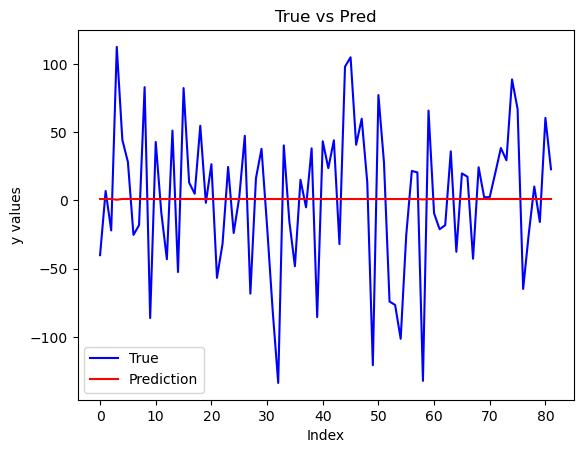

RMSE: 53.31972321154814, MAE: 42.71291484214664, R2: -0.0006858535370437568
Epoch 1/10


C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2401.4111 - mae: 38.3736 - val_loss: 3178.8379 - val_mae: 40.1737
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2441.6560 - mae: 37.2089 - val_loss: 3176.5137 - val_mae: 40.1600
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1981.0908 - mae: 34.6540 - val_loss: 3171.7063 - val_mae: 40.1321
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2210.9226 - mae: 36.1845 - val_loss: 3167.3806 - val_mae: 40.1067
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2359.1692 - mae: 38.0035 - val_loss: 3164.5625 - val_mae: 40.0902
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2124.2253 - mae: 36.1855 - val_loss: 3160.0007 - val_mae: 40.0634
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2311.5869 - mae: 37.3498 - val_loss: 3155.3984 - val_mae: 40.0360
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2298.2407 - mae: 37.5436 - val_loss: 3151.2590 - val_mae: 40.0111
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━

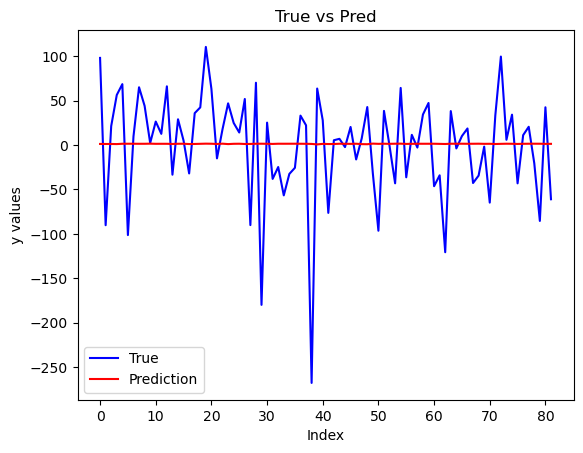

RMSE: 59.87588030754339, MAE: 43.67185727595722, R2: -0.001954310211194743
Epoch 1/10


C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2754.2495 - mae: 37.8268 - val_loss: 2690.1636 - val_mae: 44.9077
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2161.3350 - mae: 35.2087 - val_loss: 2692.1006 - val_mae: 44.8926
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2414.5186 - mae: 38.0364 - val_loss: 2693.0735 - val_mae: 44.8850
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2146.7036 - mae: 34.5414 - val_loss: 2693.9163 - val_mae: 44.8782
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2171.4714 - mae: 35.2328 - val_loss: 2694.7549 - val_mae: 44.8715
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2449.2490 - mae: 36.0182 - val_loss: 2695.3279 - val_mae: 44.8672
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2143.8330 - mae: 36.3310 - val_loss: 2696.5352 - val_mae: 44.8580
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2478.9128 - mae: 36.5773 - val_loss: 2698.2959 - val_mae: 44.8455
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━

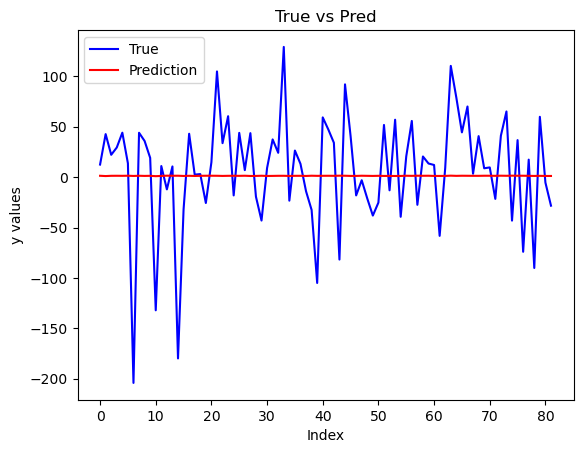

RMSE: 55.864275346732825, MAE: 41.223779862794714, R2: -0.00892707489340494
Epoch 1/10


C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3030.7717 - mae: 40.5915 - val_loss: 1604.2169 - val_mae: 35.8859
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2380.6479 - mae: 37.1000 - val_loss: 1604.1576 - val_mae: 35.8698
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3026.1929 - mae: 40.7827 - val_loss: 1604.1371 - val_mae: 35.8591
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2782.4971 - mae: 39.6721 - val_loss: 1604.1317 - val_mae: 35.8509
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2752.3086 - mae: 38.8960 - val_loss: 1604.1288 - val_mae: 35.8420
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3009.6531 - mae: 40.2915 - val_loss: 1604.1210 - val_mae: 35.8284
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2577.0295 - mae: 36.8956 - val_loss: 1604.1180 - val_mae: 35.8222
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2791.0869 - mae: 39.5237 - val_loss: 1604.1089 - val_mae: 35.8128
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━

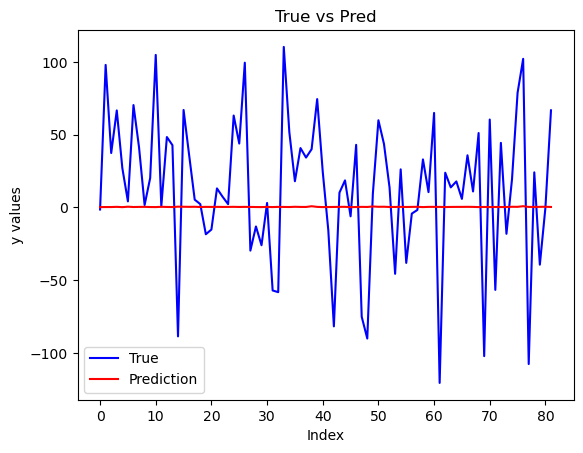

RMSE: 51.230557007189894, MAE: 40.11380387817944, R2: -0.06608934111352305
Epoch 1/10


C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2599.0256 - mae: 38.3185 - val_loss: 1975.4362 - val_mae: 37.9338
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2509.6514 - mae: 39.0904 - val_loss: 1972.4054 - val_mae: 37.9157
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2369.9473 - mae: 38.2271 - val_loss: 1969.8102 - val_mae: 37.9001
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2471.0115 - mae: 39.2511 - val_loss: 1967.3300 - val_mae: 37.8852
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2627.9929 - mae: 39.6511 - val_loss: 1965.3330 - val_mae: 37.8731
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2988.6445 - mae: 42.4351 - val_loss: 1962.2812 - val_mae: 37.8545
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2567.7083 - mae: 38.3042 - val_loss: 1958.5824 - val_mae: 37.8319
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2531.9414 - mae: 38.8745 - val_loss: 1955.1315 - val_mae: 37.8106
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━

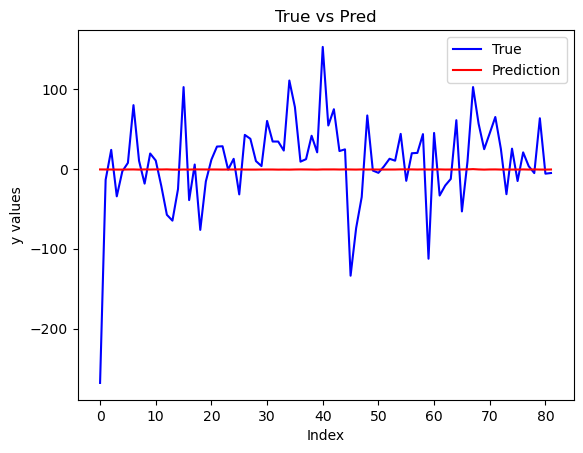

RMSE: 56.24447431984608, MAE: 38.960703718290006, R2: -0.029299699117248723
The average test RMSE over 10 iterations for MEF monthly data is: 52.63909997216916


In [25]:
# Test the performance of the model on 10 different random train-test splits of MEF monthly data, and report the average RMSE.
list_RMSE_train_train2=[]
list_RMSE_train_val2=[]
list_RMSE2=[]

np.random.seed(11)
random.seed(11)

for i in range(0,10):
  # Generate training and test data sets
  X_train, y_train, X_test, y_test = split_data(X_mef_m, y_mkt_m, 0.2, i)

  # Use X_train and y_train as MAI features and target variable
  trained_model, training_history, avg_RMSE_train, avg_RMSE_test = train_neural_network_MEF(X_train, y_train)
  print('During training of this NN model, average training RMSE is', avg_RMSE_train, ', average validation RMSE is', avg_RMSE_test)
  list_RMSE_train_train2.append(avg_RMSE_train)
  list_RMSE_train_val2.append(avg_RMSE_test)

  # Have the performance of the trained model evaluated on the test set
  MSE, MAE, R2 = test_model(trained_model, X_test, y_test)
  print(f'RMSE: {MSE**(1/2)}, MAE: {MAE}, R2: {R2}')
  list_RMSE2.append(MSE**(1/2))
avg_RMSE2=np.mean(list_RMSE2)
print(' ')
print('The average test RMSE over 10 iterations for MEF monthly data is:', avg_RMSE2)

Text(0.5, 1.0, 'Distribution of RMSE over Iterations (MEF monthly training data)')

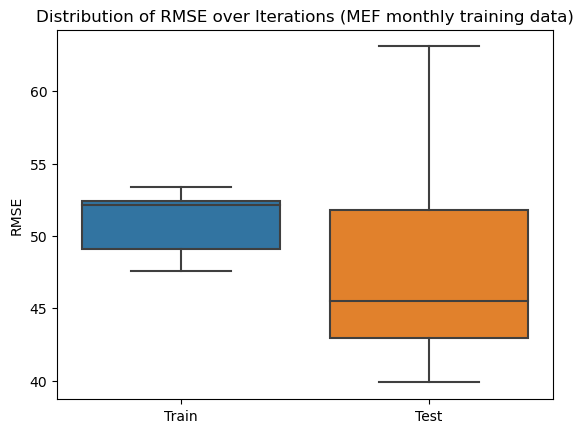

In [13]:
sns.boxplot(data=[list_RMSE_train_train2, list_RMSE_train_val2])
plt.xticks([0, 1], ['Train', 'Test'])
plt.ylabel('RMSE')
plt.title('Distribution of RMSE over Iterations (MEF monthly training data)')

## Neural Networks with daily data

Now we will train again using the daily datasets. Since the size of them seems sufficient enough for getting robust results from the training of the networks, we will do only do one training.

We start with the MAI daily dataset.

Epoch 1/10


C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3061.6040 - mae: 40.6681 - val_loss: 2887.9668 - val_mae: 40.3989
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3131.9958 - mae: 40.4400 - val_loss: 2873.4368 - val_mae: 40.1598
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3091.7537 - mae: 40.4387 - val_loss: 2863.5020 - val_mae: 39.9796
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2855.3127 - mae: 39.4891 - val_loss: 2857.7014 - val_mae: 39.8699
Epoch 5/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3006.3123 - mae: 40.0196 - val_loss: 2853.3215 - val_mae: 39.7800
Epoch 6/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2905.0544 - mae: 38.9479 - val_loss: 2850.1541 - val_mae: 39.7114
Epoch 7/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2994.2354 - mae: 39.6217 - val_loss: 2847.8071 - val_mae: 39.6541
Epoch 8/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2917.1140 - mae: 39.2820 - val_loss: 2847.0181 - val_mae: 39.6422
Epo

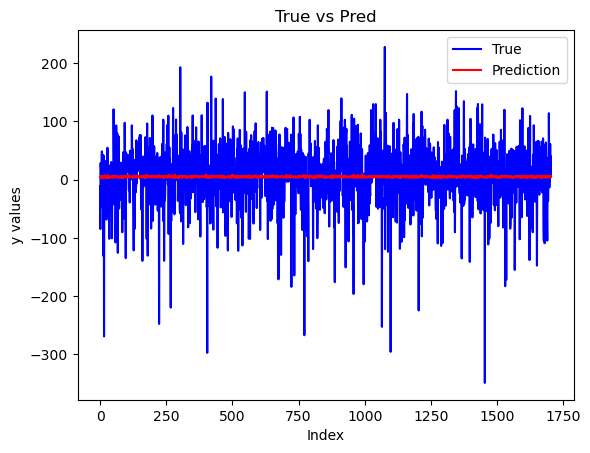

RMSE: 54.18099136715748, MAE: 39.58806130662329, R2: -0.0023162605456135132
 
The test RMSE for MAI daily data is: 54.18099136715748


In [27]:
# Test the performance of the model on 10 different random train-test splits of MAI daily data, and report the average RMSE.
list_RMSE_train_train1=[]
list_RMSE_train_val1=[]
list_RMSE1=[]
num_iterations = 1

for i in range(0,num_iterations):
  # Generate training and test data sets
  X_train, y_train, X_test, y_test = split_data(X_mai_d, y_mkt_d, 0.2, i)

  # Use X_train and y_train as MAI features and target variable
  trained_model, training_history, avg_RMSE_train, avg_RMSE_test = train_neural_network_MAI(X_train, y_train)
  print('During training of this NN model, average training RMSE is', avg_RMSE_train, ', average validation RMSE is', avg_RMSE_test)
  list_RMSE_train_train1.append(avg_RMSE_train)
  list_RMSE_train_val1.append(avg_RMSE_test)

  # Have the performance of the trained model evaluated on the test set
  MSE, MAE, R2 = test_model(trained_model, X_test, y_test)
  print(f'RMSE: {MSE**(1/2)}, MAE: {MAE}, R2: {R2}')
  list_RMSE1.append(MSE**(1/2))
avg_RMSE1=np.mean(list_RMSE1)
print(' ')
print('The test RMSE for MAI daily data is:', avg_RMSE1)

Now we do the same for the MEF daily data.

Epoch 1/10


C:\Users\ANDREAS\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2969.1128 - mae: 39.9927 - val_loss: 2856.9441 - val_mae: 39.8586
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3017.9792 - mae: 39.8242 - val_loss: 2851.1594 - val_mae: 39.7419
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3150.5464 - mae: 40.2275 - val_loss: 2848.3562 - val_mae: 39.6773
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2899.1992 - mae: 38.8516 - val_loss: 2846.2041 - val_mae: 39.6194
Epoch 5/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3006.0649 - mae: 39.4991 - val_loss: 2845.5791 - val_mae: 39.6017
Epoch 6/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3045.6641 - mae: 39.9105 - val_loss: 2845.0728 - val_mae: 39.5869
Epoch 7/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3214.8958 - mae: 40.3579 - val_loss: 2844.6147 - val_mae: 39.5729
Epoch 8/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2919.2378 - mae: 39.3599 - val_loss: 2844.1177 - val_mae: 39.5513
Epo

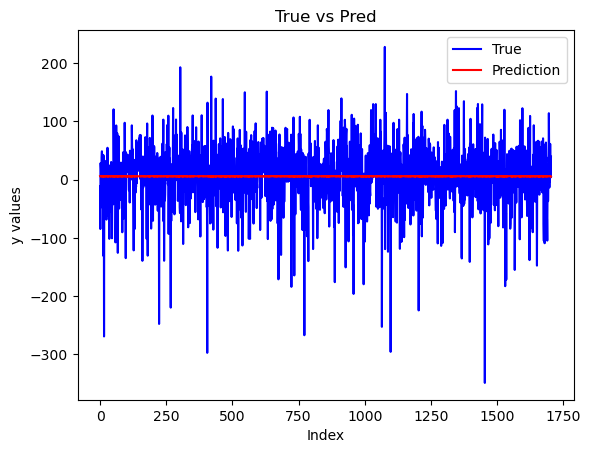

RMSE: 54.161556672183806, MAE: 39.51472019466719, R2: -0.0015973288089259352
The test RMSE for MEF daily data is: 54.161556672183806


In [28]:
# Test the performance of the model on 10 different random train-test splits of MEF daily data, and report the average RMSE.
list_RMSE_train_train3=[]
list_RMSE_train_val3=[]
list_RMSE3=[]
num_iterations = 1

for i in range(0,num_iterations):
  # Generate training and test data sets
  X_train, y_train, X_test, y_test = split_data(X_mef_d, y_mkt_d, 0.2, i)

  # Use X_train and y_train as MAI features and target variable
  trained_model, training_history, avg_RMSE_train, avg_RMSE_test = train_neural_network_MEF(X_train, y_train)
  print('During training of this NN model, average training RMSE is', avg_RMSE_train, ', average validation RMSE is', avg_RMSE_test)
  list_RMSE_train_train3.append(avg_RMSE_train)
  list_RMSE_train_val3.append(avg_RMSE_test)

  # Have the performance of the trained model evaluated on the test set
  MSE, MAE, R2 = test_model(trained_model, X_test, y_test)
  print(f'RMSE: {MSE**(1/2)}, MAE: {MAE}, R2: {R2}')
  list_RMSE3.append(MSE**(1/2))
avg_RMSE3=np.mean(list_RMSE3)
print(' ')
print('The test RMSE for MEF daily data is:', avg_RMSE3)